In [1]:
import numpy as np
import random
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
Battary_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('CALCE.npy', allow_pickle=True)
Battery = Battery.item()

D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


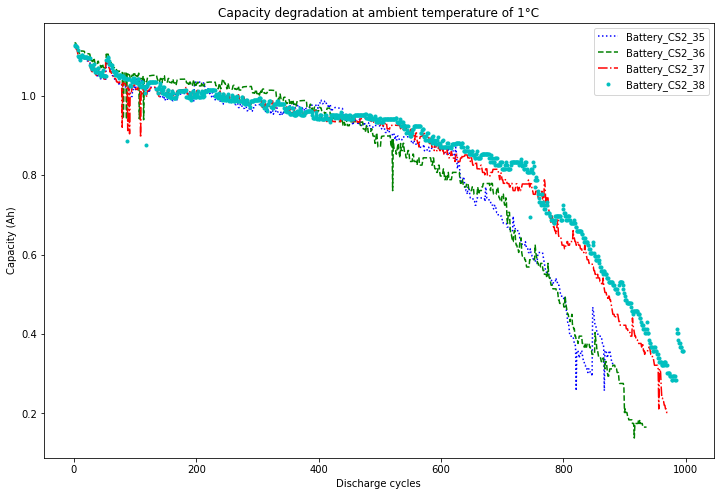

In [4]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battary_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [5]:
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [6]:
class Net(nn.Module):
    def __init__(self, k=3, eps=1e-6):
        super(Net, self).__init__()
        self.eps = eps
        self.w = torch.nn.Parameter(torch.randn((3, k)), requires_grad=True)
        
    def forward(self, x): 
        out = 0
        for i in range(k):
            out += self.w[0, i] * torch.exp(-torch.pow((x - self.w[1, i])/(self.w[2, i] + self.eps), 2)) 
        return out

In [7]:
def train(data, k=3, lr=1e-4, stop=1e-3, epochs=100000, device=device):  
    model = Net(k=k)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    loss_list = []
    epoch = 0
    while True:
        train_data = np.random.permutation(data)
        x, y = train_data[:,0], train_data[:,1]
        X, y = np.reshape(x, (-1, 1)).astype(np.float32), np.reshape(y, (-1, 1)).astype(np.float32)
        X, y = Variable(torch.from_numpy(X)).to(device), Variable(torch.from_numpy(y)).to(device)
        y_ = model(X)
        loss = criterion(y_, y)
        #print(loss.detach().numpy())
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients
        
        if epoch % 100 == 0:
            loss_list.append(loss.detach().numpy())
            
        if (loss.detach().numpy() < stop) or (epoch > epochs):
            break
            
        epoch +=1

    return model, loss_list


def predict(model, x, device=device):
    x = np.array(x).astype(np.float32)
    x= torch.from_numpy(x).to(device)
    model.eval()
    torch.no_grad()
    y_ = model(x)
    return y_.detach().numpy()

In [8]:
lr = 1e-2    # learning rate
k = 3
stop = 1e-3
epochs = 100000

seed = 0
print('seed: ', seed)
setup_seed(seed=seed)

i = 0
name = Battary_list[i]
df = Battery[name]
x, y = np.array(df['cycle']), np.array(df['capacity'])

model, loss_list = train(data=np.c_[x, y], k=k, lr=lr, stop=stop, epochs=epochs, device=device)
print('Optimal parameters: ', model.w)

seed:  0
Optimal parameters:  Parameter containing:
tensor([[ 106.4594,  -91.1130,  -19.7342],
        [ 286.9670,  314.5258,  152.2022],
        [ 302.1231,  289.4315, -262.6197]], requires_grad=True)


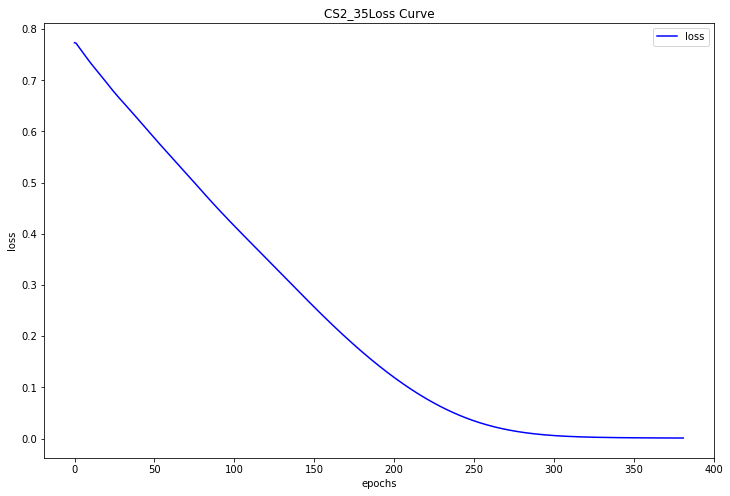

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot([i for i in range(len(loss_list))], loss_list, 'b-', label='loss')
ax.set(xlabel='epochs', ylabel='loss', title=name + 'Loss Curve')
plt.legend()

In [10]:
y_ = predict(model, x, device=device)

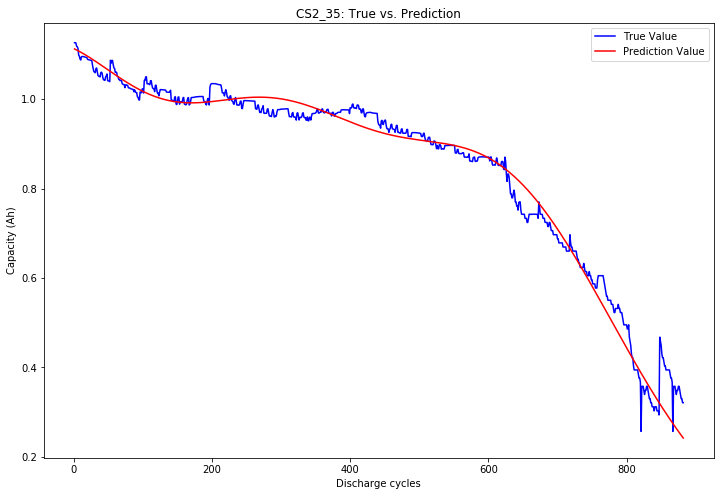

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(x, y, 'b-', label='True Value')
ax.plot(x, y_, 'r-', label='Prediction Value')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title=name + ': True vs. Prediction')
plt.legend()